In [1]:
import numpy as np
# from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
# from sklearn.manifold import t_sne
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib import pyplot as plt
import os
import kaldi_io
import kaldiio
import torch
from tqdm import tqdm
from scipy.stats import norm
import statistics
from scipy import stats
import pandas as pd
import seaborn as sns
# import ot

from Misc.OptimalTransport.optimal_transport import compute_optimal_transport, OptimalTransport

plt.rc('font', family='Times New Roman', weight='semibold')
# import seaborn as sns
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# palette = sns.color_palette("bright", 10)

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from Define_Model.TDNN.TDNN import TDNN_v5
from Define_Model.Loss.SoftmaxLoss import AdditiveMarginLinear

data_dir = '/home/yangwenhao/project/SpeakerVerification-pytorch'
lstm_dir = '/home/yangwenhao/project/lstm_speaker_verification/data'

In [ ]:
tdnn_xvector_dir = 'Data/xvector/TDNN_v5/cnceleb/klfb_egs_baseline/arcsoft/Mean_STAP_em512_wd5e4_var/cnceleb_dev_epoch50_fix/test'
tdnn_xvector_dict = {}
with open(os.path.join(data_dir, tdnn_xvector_dir, 'xvectors.scp'), 'r') as f:
    for l in f.readlines():
        uid,upath = l.split()
        tdnn_xvector_dict[uid] = upath
    
spk2uid_dict = {}
for uid in tdnn_xvector_dict:
    sid,_,_,_ = uid.split('-')
    spk2uid_dict.setdefault(sid, []).append(uid)  

In [4]:
tdnn_ckp_dir = 'Data/checkpoint/TDNN_v5/cnceleb/klfb_egs_baseline/arcsoft_sgd_rop/Mean_STAP_em512_wd5e4_var/checkpoint_9.pth'
tdnn_model = torch.load(data_dir + "/" + tdnn_ckp_dir)

model = TDNN_v5(num_classes=797, embedding_size=512, input_dim=40, alpha=0., input_norm='Mean',
                 encoder_type='STAP', block_type='basic', stride=[1], channels=[512, 512, 512, 512, 1500])
model.classifier = AdditiveMarginLinear(feat_dim=512, num_classes=797)
model.load_state_dict(tdnn_model['state_dict'])

/home/yangwenhao/project/SpeakerVerification-pytorch/Define_Model/Loss/SoftmaxLoss.py:167: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.W, gain=1)


<All keys matched successfully>

In [17]:
def feature_encode(model, feat, layer=1):
    x = model.input_mask(feat)
    if len(x.shape) == 4:
        x = x.squeeze(1).float()
    # x = x.transpose(1, 2)
    if layer == 0:
        return x
    x = model.frame1(x)
    if layer == 1:
        return x
    
    x = model.frame2(x)
    if layer == 2:
        return x
    
    x = model.frame3(x)
    if layer == 3:
        return x
    
    x = model.frame4(x)
    if layer == 4:
        return x
    
    x = model.frame5(x)
    if layer == 5:
        return x

    if model.dropout_layer:
        x = model.drop(x)
    x = model.encoder(x)
    if layer == 6:
        return x
#     print(x.shape)
    
    x = model.segment6(x)
    if layer == 7:
        return x

    x = model.segment7(x)
    if layer == 8:
        return x
    
    return x

In [6]:
classifier_Center = tdnn_model['state_dict']['classifier.W'].cpu()
print(classifier_Center.shape)

classifier_Center[:,1].shape

torch.Size([512, 797])


torch.Size([512])

In [7]:
cnc_dir = 'cnceleb/dev/wav.scp'
spk_domain_dict = {}
domains = set([])

with open(os.path.join(lstm_dir, cnc_dir), 'r') as f:
    
    for l in f.readlines():
        uid,upath = l.split()[:2]
        
        sid, domain,_,_ = uid.split('-')
        domains.add(domain)
        if sid in spk_domain_dict:
            spk_domain_dict[sid].add(domain)
        else:
            spk_domain_dict[sid] = set([domain])

In [8]:
cnc_dir = 'cnceleb/klfb/dev_fb40'
uid2upath = {}

with open(os.path.join(lstm_dir, cnc_dir, 'feats.scp'), 'r') as f:
    for l in f.readlines():
        uid,upath = l.split()
        uid2upath[uid] = upath

spk2uid_dict = {}
with open(os.path.join(lstm_dir, cnc_dir, 'spk2utt'), 'r') as f:
    for l in f.readlines():
        spk2uid_dict[l.split()[0]] = l.split()[1:]

In [21]:
multi_spks = []
for spk in spk_domain_dict:
    if len(spk_domain_dict[spk]) > 2:
        multi_spks.append(spk)
# print(multi_spks)

target_spks = []
target_doms = set([])

for i, spk in enumerate(multi_spks):
    target_spks = [spk]
    target_doms = set(spk_domain_dict[spk]) 
    for other_spk in multi_spks[i+1:]:
#         if len( target_doms & set(spk_domain_dict[other_spk]) ) > 1:
#             print(spk, other_spk, len( target_doms | set(spk_domain_dict[other_spk]) ))
            
        if len( target_doms | set(spk_domain_dict[other_spk]) ) > 5 or len( target_doms & set(spk_domain_dict[other_spk]) ) < 3:
            continue
        else:
            target_spks.append(other_spk)
            target_doms = target_doms | set(spk_domain_dict[other_spk])
            
        if len(target_spks) > 5:
            break
            
    if len(target_spks) > 5:
        break

In [22]:
print(target_doms)
print(target_spks)
for t in target_spks:
    print(t, spk_domain_dict[t])

{'singing', 'entertainment', 'interview', 'live_broadcast'}
['id00004', 'id00018', 'id00056', 'id00057', 'id00061', 'id00064']
id00004 {'interview', 'singing', 'entertainment'}
id00018 {'interview', 'singing', 'entertainment'}
id00056 {'interview', 'singing', 'entertainment'}
id00057 {'interview', 'singing', 'entertainment'}
id00061 {'interview', 'singing', 'live_broadcast', 'entertainment'}
id00064 {'interview', 'singing', 'live_broadcast'}


In [23]:
# spk_domain_dict['id00007']
# all_sids = ["id00038", "id00094","id00061", "id00070", 'id00096', 'id00100']
all_sids = target_spks
all_sid2idx = {s: i for i,s in enumerate(all_sids)}

In [24]:
model = model.cuda()
model.eval()

layer_features = {}
layers = [0, 1, 2, 3, 4, 5, 7, 8]
for layer in layers:
    feat_maps = []
    fm_uids = []
    for this_sid in all_sids:
        this_spks_feat = []
        for uid in spk2uid_dict[this_sid]:
            this_spks_feat.append([uid, kaldiio.load_mat(uid2upath[uid])])

        for uid, feat in this_spks_feat:
            if len(feat) > 300:
                for i in range(int(len(feat)/300)):
                    start = i*300
                    end =  i*300+300
                    
                    if i*300+300 > len(feat):
                        end = len(feat)
                        start = end - 300
                        
                    this_feat = feat[start:end]
                    this_feat = torch.tensor(this_feat[:, 1:]).unsqueeze(0).cuda()
                    fm_uids.append(uid+'-%d'%i)
        
                    feat_maps.append(feature_encode(model, this_feat, layer).squeeze().cpu().detach().numpy())

    feat_gid = [uid.split('-')[1] for uid in fm_uids]    
    feat_sid = [uid.split('-')[0] for uid in fm_uids]    
#     for f in feat_maps:
#         print(f.shape, end=' ')
        
    np_feat_maps = np.array(feat_maps)
    layer_features[layer] = [np_feat_maps, feat_sid, feat_gid]

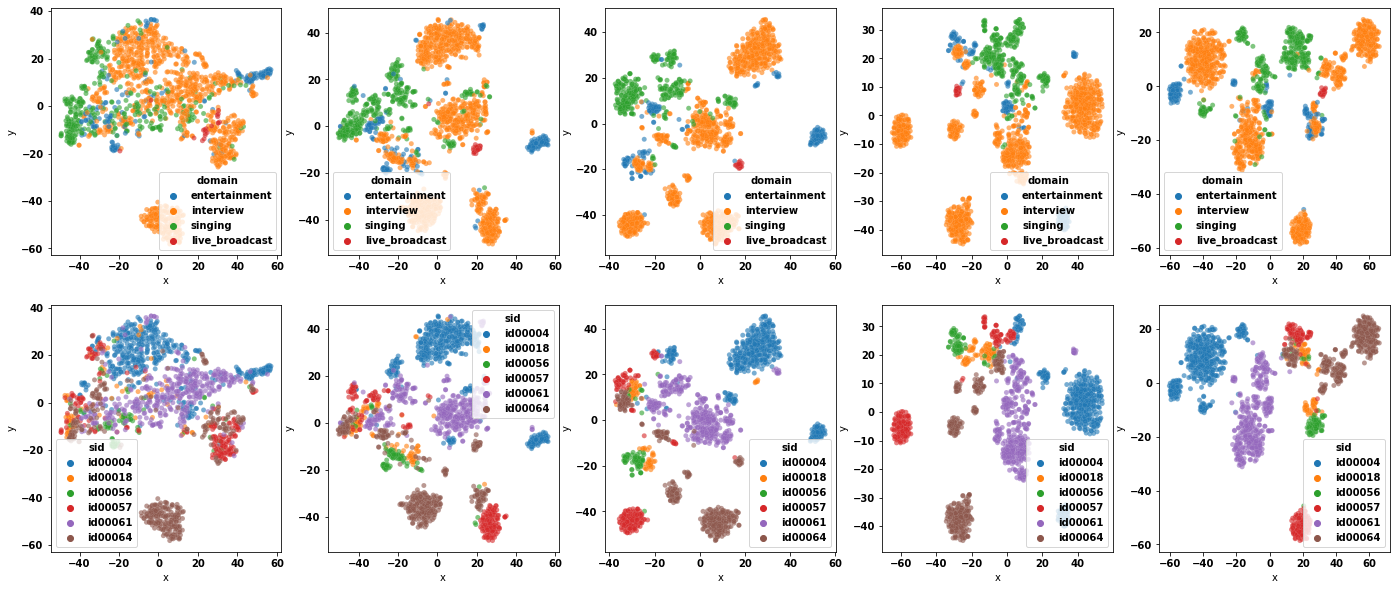

In [25]:
plt.figure(figsize=(24, 10))
layers = [0, 1, 4, 5, 8]
pca_dim=512

for i,j in enumerate(layers):
    np_feat_maps, feat_sid, feat_gid = layer_features[j]

    if len(np_feat_maps.shape) == 3:
        np_feat_maps = np.concatenate([np_feat_maps.mean(axis=1),np_feat_maps.std(axis=1)], axis=1) 
    
    if np_feat_maps.shape[-1] > pca_dim:
        feat = PCA(n_components=pca_dim).fit_transform(np_feat_maps)
    else:
        feat = np_feat_maps
    # embedded_feat = TSNE(n_components=2, init='pca').fit_transform(feat_pca)
    embedded_feat = TSNE(n_components=2, init='pca').fit_transform(feat)

    pd_emb_feat = pd.DataFrame(embedded_feat, columns=['x', 'y'])
    pd_emb_feat.insert(2, 'domain', feat_gid)
    pd_emb_feat.insert(3, 'sid',    feat_sid)
    
    plt.subplot(2,len(layers),i+1)
    sns.scatterplot(data=pd_emb_feat, x='x', y='y', hue='domain', s=25, alpha=0.6, linewidth=0.1)
    
    plt.subplot(2,len(layers),i+1+len(layers))
    sns.scatterplot(data=pd_emb_feat, x='x', y='y', hue='sid', s=25, alpha=0.6, linewidth=0.1)
    
plt.savefig('imgs/layer_stat_style_pca%d.png'%(pca_dim), bbox_inches='tight')

In [16]:
domains = list(domains)
domains.sort()
domain2idx = {uid:i for i,uid in enumerate(domains)}

spks = list(spk_domain_dict.keys())
spks.sort()
spk2idx = {sid:i for i,sid in enumerate(spks)}

In [17]:
print(list(spk_domain_dict.keys())[:10])

['id00000', 'id00001', 'id00002', 'id00003', 'id00004', 'id00005', 'id00006', 'id00007', 'id00008', 'id00009']


In [18]:
numofdomains_spk = 4
numofdomains = []
for sid in spks:
    numofdomains.append(len(spk_domain_dict[sid]))
    if len(spk_domain_dict[sid]) >= numofdomains_spk:
        print(sid, end='", "')
# id00004

id00038", "id00047", "id00061", "id00070", "id00094", "id00096", "id00100", "id00108", "id00113", "id00130", "id00138", "id00152", "id00182", "id00210", "id00217", "id00222", "id00223", "id00258", "id00291", "id00304", "id00305", "id00307", "id00346", "id00351", "id00374", "id00376", "id00392", "id00394", "id00404", "id00406", "id00410", "id00412", "id00436", "id00448", "id00453", "id00458", "id00459", "id00464", "id00472", "id00476", "id00482", "id00489", "id00491", "id00498", "id00500", "id00504", "id00510", "id00522", "id00523", "id00533", "id00550", "id00555", "id00556", "id00557", "id00559", "id00601", "id00623", "id00664", "id00687", "id00693", "id00702", "id00738", "id00740", "id00747", "id00757", "id00769", "

In [107]:
all_sids = ["id00038", "id00061", "id00070", "id00094", "id00096"]
all_sid2idx = {s: i for i,s in enumerate(all_sids)}
# plt.figure(figsize=(24,6))
spk2dom2cos = {}
spk2vectors = {}
allvectors = []

for i, this_sid in enumerate(all_sids):
    # ax = plt.subplot(1,len(all_sids),i+1)
    j=0
    
    one_xvectors_dict = {}
    one_xvectors = []
    one_xvectors_dom = []
    one_xvectors_dom2cos = {}
    one_xvectors_domidx = []
    this_spk_center = classifier_Center[:, spk2idx[this_sid]]
    
    for uid in spk2uid_dict[this_sid]:
        this_vector = kaldi_io.read_vec_flt(data_dir + '/'+ tdnn_xvector_dict[uid])
        this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(this_vector), dim=0) 

        one_xvectors_dict[uid] = this_vector
        one_xvectors.append(this_vector)
        dom = uid.split('-')[1]
        one_xvectors_dom.append(dom)
        one_xvectors_dom2cos.setdefault(dom,[]).append(float(this_cos))
        one_xvectors_domidx.append(domain2idx[dom])
        
        allvectors.append([this_sid, this_vector, dom])

    # allvectors.extend(one_xvectors)
    one_xvectors = np.array(one_xvectors)
    spk2vectors[this_sid] = one_xvectors

In [112]:
pd_allvectors = pd.DataFrame(allvectors,columns=['sid','vector', 'domain'])
vectors = np.array([i for i in pd_allvectors['vector'].values])
spkidxs = [all_sid2idx[s] for s in list(pd_allvectors['sid'].values)]

In [113]:
vectors = PCA(n_components=64).fit_transform(vectors)

all_embeddeds = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(vectors)
#     one_xvectors_dom = np.array(one_xvectors_dom
pd_embeddeds = pd.DataFrame(all_embeddeds,columns=['x','y'])
pd_embeddeds.insert(2, 'sid', pd_allvectors['sid'])
pd_embeddeds.insert(3, 'domain', pd_allvectors['domain'])

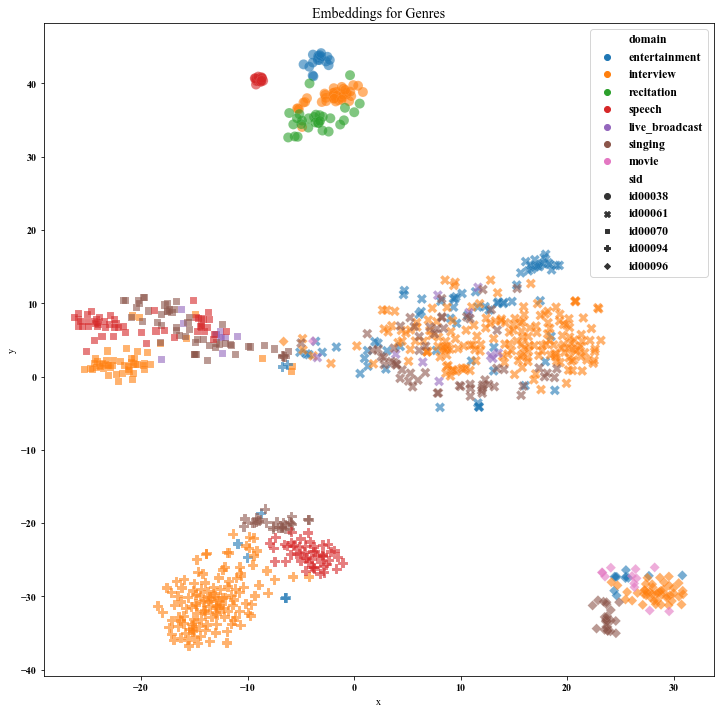

In [114]:
plt.figure(figsize=(12,12))
plt.title('Embeddings for Genres', fontsize=14)
sns.scatterplot(data=pd_embeddeds, x='x', y='y', hue='domain', style='sid', s=100, alpha=0.6, linewidth=0.1)
plt.legend(fontsize=12)

In [115]:
# 
spk1 = pd_embeddeds[pd_embeddeds['sid'] == all_sids[0]]
spk2 = pd_embeddeds[pd_embeddeds['sid'] == all_sids[1]]

n, m = len(spk1), len(spk2)
spk1_np = spk1.filter(items=['x', 'y']).values
spk2_np = spk2.filter(items=['x', 'y']).values

ot2d = OptimalTransport(spk1_np, spk2_np, lam=0.5, fit_mapping=False,)

1.0

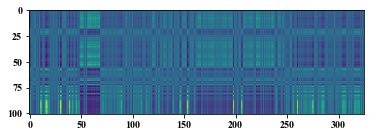

In [116]:
plt.imshow(ot2d.P)
np.sum(ot2d.P)

In [25]:
# fig, ax = plt.subplots()

# # ax.scatter(spk1_np[:,0], spk1_np[:,1], color='blue')
# # ax.scatter(spk2_np[:,0], spk2_np[:,1], color='orange')
# ax.scatter(spk1_np[:,0], spk1_np[:,1], color='blue', label='set 1')
# ax.scatter(spk2_np[:,0], spk2_np[:,1], color='orange', label='set 2')

# ax.legend(loc=0)

# for i in range(n):
#     for j in range(m):
#         if ot2d.P[i,j] > 1e-5:
#             ax.plot([spk1_np[i,0], spk2_np[j,0]], [spk1_np[i,1], spk2_np[j,1]], alpha=ot2d.P[i,j] * n, color='red')

In [ ]:
A = np.ones((2,2))*0.1
B = np.random.randn(2,2)
print(A)
print(B)

C = A.T @ B
print(C)

print(np.matmul(A.T, B)) # @ matric mul

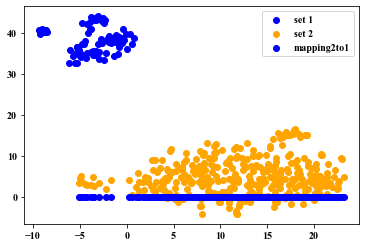

In [117]:
X, w = ot2d.interpolate(0.6)
ot2d.fit_mapping()
fig, ax = plt.subplots()

ax.scatter(spk1_np[:,0], spk1_np[:,1], color='blue', label='set 1')
ax.scatter(spk2_np[:,0], spk2_np[:,1], color='orange', label='set 2')
ax.scatter(spk2_np[:,0], ot2d.mapX2toX1(spk2_np)[:, 1], color='blue', label='mapping2to1')

# ax.scatter(X[:,0], X[:,1], color='red', label='interpolation')
ax.legend(loc=0)

In [118]:
ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=spk1_np, Xt=spk2_np)
transp_Xs_emd = ot_emd.transform(Xs=spk1_np)

<AxesSubplot:xlabel='x', ylabel='y'>

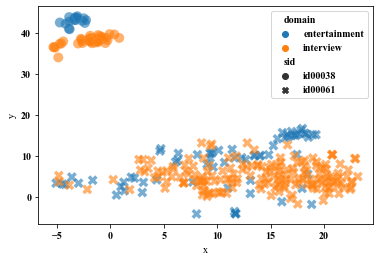

In [121]:
spk1_ds = spk1[spk1.domain.isin(['entertainment', 'interview'])]
spk2_ds = spk2[spk2.domain.isin(['entertainment', 'interview'])]

sns.scatterplot(data=spk1_ds.append(spk2_ds), x='x', y='y', hue='domain', style='sid', s=100, alpha=0.6, linewidth=0.1)

<AxesSubplot:xlabel='x', ylabel='y'>

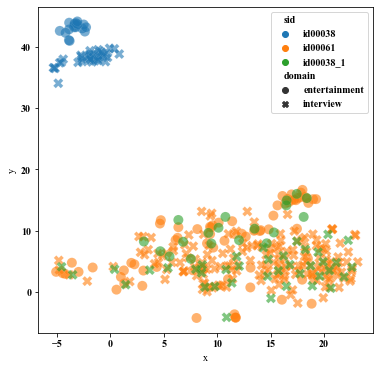

In [142]:
spk1_ds_np = spk1_ds.filter(items=['x', 'y']).values
spk2_ds_np = spk2_ds.filter(items=['x', 'y']).values

ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=spk1_ds_np, Xt=spk2_ds_np)
transp_spk1ds_emd = ot_emd.transform(Xs=spk1_ds_np)

pd_transp_spk1_ds = pd.DataFrame(transp_spk1ds_emd, columns=['x', 'y'])
pd_transp_spk1_ds.insert(2, 'sid', ['id00038_1']*len(pd_transp_spk1_ds))
pd_transp_spk1_ds.insert(3, 'domain', spk1_ds['domain'])

plt.figure(figsize=(6,6))
spk12_ds  = spk1_ds.append(spk2_ds)
spk121_ds  = spk12_ds.append(pd_transp_spk1_ds)
sns.scatterplot(data=spk121_ds, x='x', y='y', hue='sid', style='domain', s=100, alpha=0.6, linewidth=0.1)


<AxesSubplot:xlabel='x', ylabel='y'>

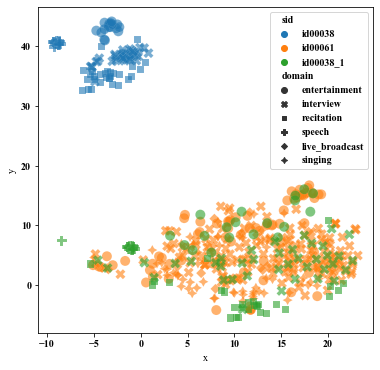

In [143]:
transp_spk1_emd = ot_emd.transform(Xs=spk1_np)

pd_transp_spk1 = pd.DataFrame(transp_spk1_emd, columns=['x', 'y'])
pd_transp_spk1.insert(2, 'sid', ['id00038_1']*len(spk1_np))
pd_transp_spk1.insert(3, 'domain', spk1['domain'])

spk12  = spk1.append(spk2)
spk121  = spk12.append(pd_transp_spk1)

plt.figure(figsize=(6,6))
sns.scatterplot(data=spk121, x='x', y='y', hue='sid', style='domain', s=100, alpha=0.6, linewidth=0.1)

<AxesSubplot:xlabel='x', ylabel='y'>

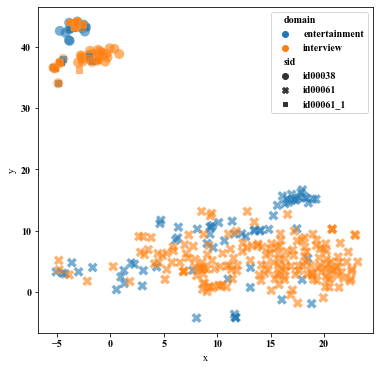

In [144]:
ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=spk2_ds_np, Xt=spk1_ds_np)
transp_spk2ds_emd = ot_emd.transform(Xs=spk2_ds_np)

pd_transp_spk2_ds = pd.DataFrame(transp_spk2ds_emd, columns=['x', 'y'])
pd_transp_spk2_ds.insert(2, 'sid', ['id00061_1']*len(pd_transp_spk2_ds))
pd_transp_spk2_ds.insert(3, 'domain', spk1_ds['domain'])

plt.figure(figsize=(6,6))
spk12_ds  = spk1_ds.append(spk2_ds)
spk121_ds  = spk12_ds.append(pd_transp_spk2_ds)
sns.scatterplot(data=spk121_ds, x='x', y='y', hue='domain', style='sid', s=100, alpha=0.6, linewidth=0.1)

<AxesSubplot:xlabel='x', ylabel='y'>

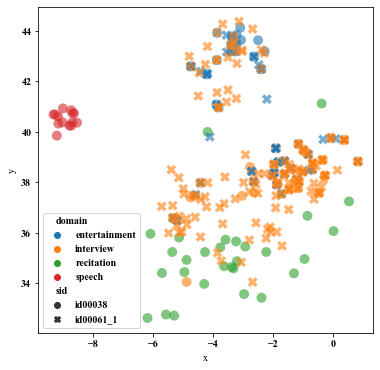

In [139]:
transp_spk2_emd = ot_emd.transform(Xs=spk2_np)

pd_transp_spk2 = pd.DataFrame(transp_spk2_emd, columns=['x', 'y'])
pd_transp_spk2.insert(2, 'sid', ['id00061_1']*len(spk2_np))
pd_transp_spk2.insert(3, 'domain', spk2['domain'])

spk12  = spk1.append(spk2)
spk121  = spk12.append(pd_transp_spk2)
spk11  = spk1.append(pd_transp_spk2)

plt.figure(figsize=(6,6))
sns.scatterplot(data=spk11, x='x', y='y', hue='domain', style='sid', s=100, alpha=0.6, linewidth=0.1)

<AxesSubplot:xlabel='x', ylabel='y'>

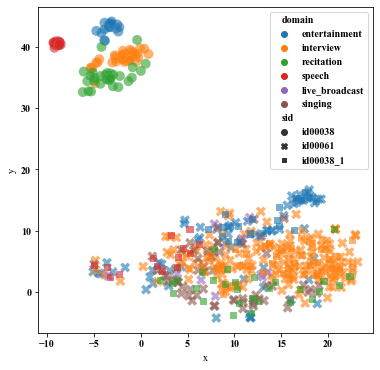

In [146]:
pd_transp_spk1 = pd.DataFrame(transp_Xs_emd, columns=['x', 'y'])
pd_transp_spk1.insert(2, 'sid', ['id00038_1']*len(pd_transp_spk1))
pd_transp_spk1.insert(3, 'domain', spk1['domain'])

spk12  = spk1.append(spk2)
spk121  = spk12.append(pd_transp_spk1)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=spk121, x='x', y='y', hue='domain', style='sid', s=100, alpha=0.6, linewidth=0.1)

In [ ]:
fig, ax = plt.subplots()

ax.scatter(spk1_np[:,0], spk1_np[:,1], color='blue', label='spk 1')
ax.scatter(spk2_np[:,0], spk2_np[:,1], color='orange', label='spk 2')
ax.scatter(transp_Xs_emd[:,0], transp_Xs_emd[:, 1], color='green', label='map_1to2')

# ax.scatter(X[:,0], X[:,1], color='red', label='interpolation')
ax.legend(loc=0)

<AxesSubplot:>

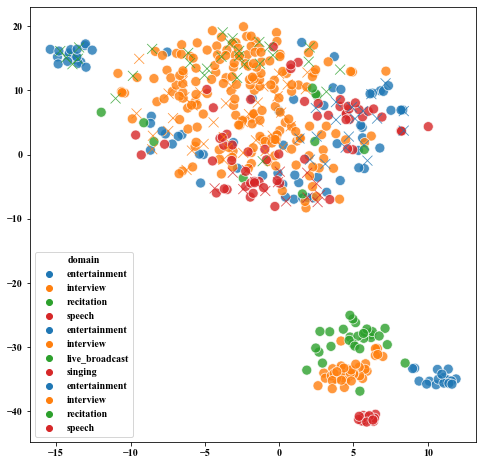

In [65]:
plt.figure(figsize=(8,8))

sns.scatterplot(x=spk1_np[:,0], y=spk1_np[:,1], hue=spk1['domain'], s=100, alpha=0.8,)
sns.scatterplot(x=spk2_np[:,0], y=spk2_np[:,1], hue=spk2['domain'], s=100, alpha=0.8,)
sns.scatterplot(x=transp_Xs_emd[:,0], y=transp_Xs_emd[:,1], hue=spk1['domain'], marker='x', s=100, alpha=0.8,)
# ax.scatter(transp_Xs_emd[:,0], transp_Xs_emd[:, 1], color='green', label='mapping1to2')

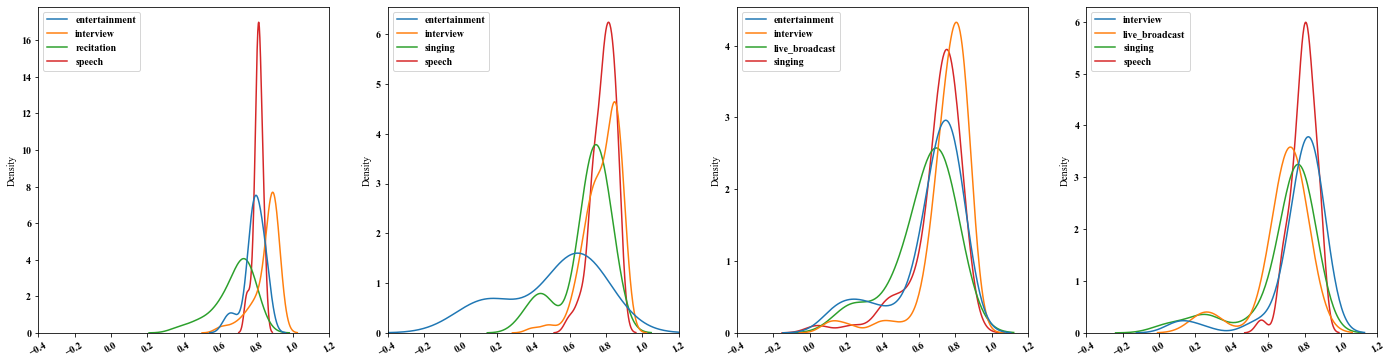

In [137]:
plt.figure(figsize=(24,6))

for i, this_sid in enumerate(all_sids):
    ax = plt.subplot(1,len(all_sids),i+1)
    j=0
    
    one_xvectors_dict = {}
    one_xvectors = []
    one_xvectors_dom = []
    one_xvectors_dom2cos = {}
    one_xvectors_domidx = []
    this_spk_center = classifier_Center[:, spk2idx[this_sid]]
    
    for uid in spk2uid_dict[this_sid]:
        this_vector = kaldi_io.read_vec_flt(data_dir + '/'+ tdnn_xvector_dict[uid])
#             print(this_vector.shape)
        this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(this_vector), dim=0) 

        one_xvectors_dict[uid] = this_vector
        one_xvectors.append(this_vector)
        dom = uid.split('-')[1]
        one_xvectors_dom.append(dom)
        one_xvectors_dom2cos.setdefault(dom,[]).append(float(this_cos))
        one_xvectors_domidx.append(domain2idx[dom])
    
    sns.kdeplot(data=one_xvectors_dom2cos, common_norm=False)
    # sns.displot(one_xvectors_dom2cos, kind="kde", bw_adjust=.25)
    
    ax.tick_params(axis='x', labelrotation=30)
    # ax.set_ylim(0, 20)
    ax.set_xlim(-0.4, 1.2)

In [161]:
miss_uid = []
all_cos = []
dom2cos = {}

for uid in tqdm(tdnn_xvector_dict, ncols=100):
    this_sid = uid.split('-')[0]
    this_spk_center = classifier_Center[:, spk2idx[this_sid]]

    this_vector = kaldi_io.read_vec_flt(data_dir + '/'+tdnn_xvector_dict[uid])
    this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(this_vector), dim=0) 
    dom = uid.split('-')[1]
    dom2cos.setdefault(dom,[]).append(float(this_cos))
    
    all_cos.append(float(this_cos))

100%|████████████████████████████████████████████████████| 111259/111259 [00:07<00:00, 13974.96it/s]


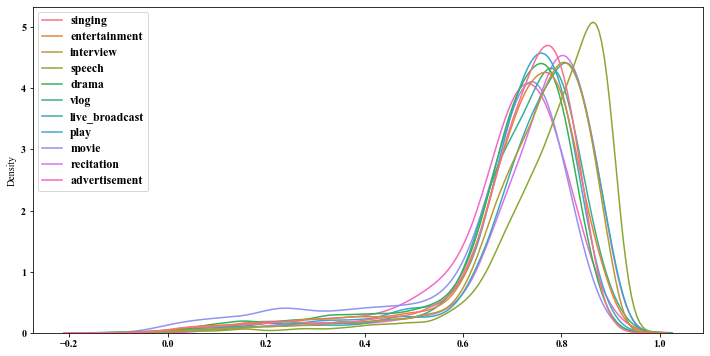

In [180]:
plt.figure(figsize=(12, 6))
ax = sns.kdeplot(data=dom2cos, common_norm=False)
_ = plt.setp(ax.get_legend().get_texts(), fontsize='12')
# lg = ax.update_params(**{'fontsize': 12})

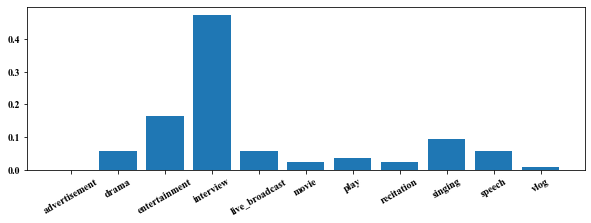

In [181]:
dom2num = []
plt.figure(figsize=(10,3))
for i,dom in enumerate(domains):
    dom2num.append(len(dom2cos[dom]))
    
plt.bar(domains, np.array(dom2num)/len(all_cos))
plt.tick_params(axis='x', labelrotation=30)

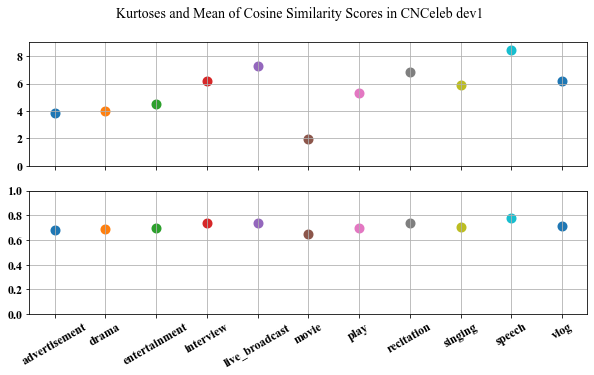

In [183]:
# x = np.arange(0, 2, 0.01)
fontsize=12
plt.figure(figsize=(10,5))
plt.suptitle("Kurtoses and Mean of Cosine Similarity Scores in CNCeleb dev1", fontsize=fontsize+2)
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
# ax3 = plt.subplot(3,1,3)

train_domain_stats = {}
for i,dom in enumerate(domains):
    dom_cos = np.array(dom2cos[dom])
    
    mean = dom_cos.mean()
    diffs = dom_cos - mean
    var = np.mean(np.power(diffs, 2.0))
    std = np.power(var, 0.5)
    z_scores = diffs / std

    kurtoses = np.mean(np.power(z_scores, 4.0)) - 3.0
#     kurtoses *= len(dom_cos)/all_cos
#     skewness = np.mean(np.power(z_scores, 3.0))
#     plt.plot(x, norm.pdf(x, mean, sd))
    ax1.scatter([dom], [kurtoses], marker='o', linewidth=4)
    ax2.scatter([dom], [mean], marker='o', linewidth=4)
#     ax3.scatter([dom], [std], marker='o', linewidth=4)
    
    train_domain_stats[dom] = [mean, std]
# plt.ylim(0,10)
# plt.xlim(0,1)
# ax1.set_xticks([])
ax1.set_xticklabels([])
# ax1.set_xticklabels([])
ax1.set_ylim(0,9)
ax2.set_ylim(0,1)
# ax2.set_xticklabels([])

for ax in [ax1, ax2]:
    ax.grid()
    ax.tick_params(axis='x', labelrotation=30)
    ax.tick_params(axis='both', labelsize=fontsize)
#     _ = ax.set_yticks(fontsize=fontsize)
#     _ = ax.set_xticks(fontsize=fontsize)
# plt.legend(list(dom2cos.keys()), fontsize=fontsize) 

# hard ==> easy
# movie adertisement drama entertainment
# vlog interview singing live_broadcast play 
# speech recitation

In [184]:
dom_center2cos = {}

for i, spk in enumerate(spk2uid_dict):
    uids = spk2uid_dict[spk]
    uids.sort()
    spk_domain_center = {}
    for uid in uids:
        dom = uid.split('-')[1]
        spk_domain_center.setdefault(dom, []).append(kaldi_io.read_vec_flt(data_dir + '/' +tdnn_xvector_dict[uid]))
    
    this_spk_center = classifier_Center[:, spk2idx[spk]]
    for dom in spk_domain_center:
        dom_center = np.array(spk_domain_center[dom])
#         print(dom_center.shape)
        dom_center = dom_center.mean(axis=0)
        this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(dom_center), dim=0)
        dom_center2cos.setdefault(dom, []).append(float(this_cos))

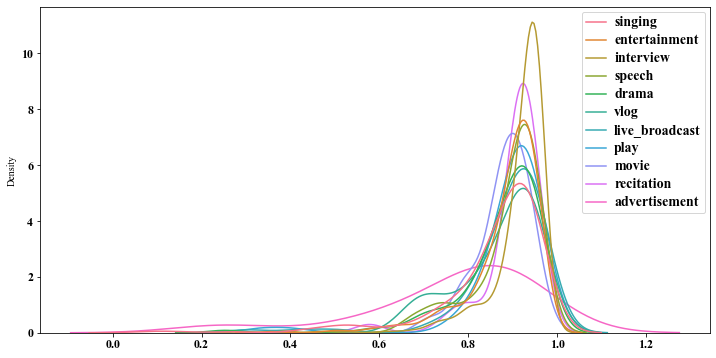

In [188]:
fontsize=12
plt.figure(figsize=(12,6))
# for i,dom in enumerate(domains):
#     ax = plt.subplot(len(dom2cos),1,i+1)
    # dom_cos = np.array(dom_center2cos[dom])
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     plt.scatter(dom_cos, [dom]*len(dom_cos), linewidths=0.1, alpha=0.2)
    # _ = plt.hist(dom_cos, alpha=0.5, bins=50, density=True, histtype='step')

ax = sns.kdeplot(data=dom_center2cos, common_norm=False)
# plt.legend(domains, fontsize=fontsize) 
_ = plt.setp(ax.get_legend().get_texts(), fontsize=fontsize+2)
_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)

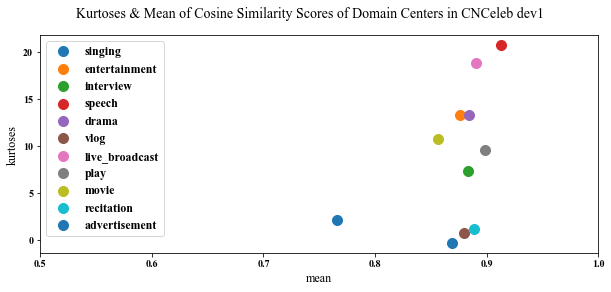

In [198]:
plt.figure(figsize=(10,4))
plt.suptitle("Kurtoses & Mean of Cosine Similarity Scores of Domain Centers in CNCeleb dev1", fontsize=fontsize+2)
# ax1 = plt.subplot(2,1,1)
# ax2 = plt.subplot(2,1,2)

domain_kurtoses = []

for i,dom in enumerate(domains):
    dom_cos = np.array(dom_center2cos[dom])
    
    mean = dom_cos.mean()
    diffs = dom_cos - mean
    var = np.mean(np.power(diffs, 2.0))
    std = np.power(var, 0.5)
    z_scores = diffs / std
    
    kurtoses = np.mean(np.power(z_scores, 4.0)) - 3.0
    domain_kurtoses.append(kurtoses)
    plt.scatter([mean], [kurtoses], marker='o', s=100)
    # ax1.scatter([dom], [kurtoses], marker='o', linewidth=4)
    # ax2.scatter([dom], [mean], marker='o', linewidth=4)
    
# ax1.set_xticklabels([])
# ax2.set_ylim(0,1)
# for ax in [ax1, ax2]:
#     ax.grid()
    
#     ax.tick_params(axis='x', labelrotation=30)
#     ax.tick_params(axis='both', labelsize=fontsize)
plt.xlim(0.5, 1)
plt.ylabel('kurtoses', fontsize=fontsize)
plt.xlabel('mean', fontsize=fontsize)
plt.legend(list(dom2cos.keys()), fontsize=fontsize) 
# Hard ==> Easy

# movie adertisement drama entertainment
# vlog interview singing live_broadcast play 
# speech recitation

In [199]:
spk_center2cos = []

for i, spk in enumerate(spks):
    uids = spk2uid_dict[spk]
    spk_center = []
    for uid in uids:
        spk_center.append(kaldi_io.read_vec_flt(data_dir + '/' +tdnn_xvector_dict[uid]))
    
    this_spk_center = classifier_Center[:, spk2idx[spk]]
    center = np.array(spk_center).mean(axis=0)
    this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(center), dim=0)
    if this_cos < 0.7:
        print(spk, ' ', end='')
        
    spk_center2cos.append(float(this_cos))

id00098  id00202  id00277  id00347  id00602  id00753  id00798  

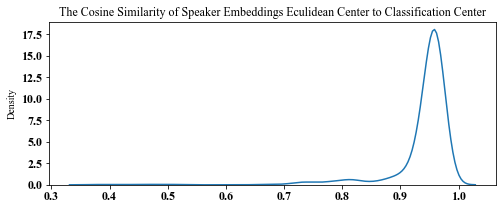

In [214]:
fontsize=12
plt.figure(figsize=(8,3))
center2cos = np.array(spk_center2cos)
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     plt.scatter(dom_cos, [dom]*len(dom_cos), linewidths=0.1, alpha=0.2)
# plt.hist(center2cos, alpha=0.5, bins=100, density=True, histtype='step')
ax = sns.kdeplot(data=center2cos, common_norm=False)

# plt.legend(domains, fontsize=fontsize) 

_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)
_ = plt.title('The Cosine Similarity of Speaker Embeddings Eculidean Center to Classification Center')

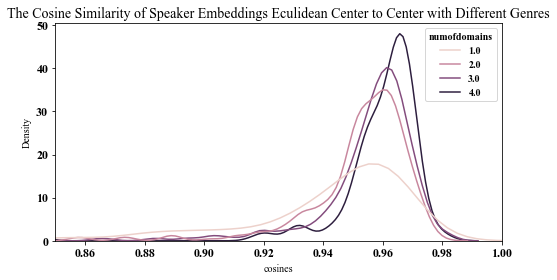

In [243]:
fontsize=12
plt.figure(figsize=(8, 4))
_ = plt.title('The Cosine Similarity of Speaker Embeddings Eculidean Center to Center with Different Genres', fontsize=fontsize+2)
center2cos = np.array(spk_center2cos)
pd_center2cos = pd.DataFrame(center2cos, columns=['cosines'])
pd_center2cos.insert(1, 'numofdomains', numofdomains)
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     plt.scatter(dom_cos, [dom]*len(dom_cos), linewidths=0.1, alpha=0.2)
# plt.hist(center2cos, alpha=0.5, bins=800, density=True, histtype='step')
filtered  = pd_center2cos.where(pd_center2cos['numofdomains']<5)
ax = sns.kdeplot(data=filtered, x='cosines', hue='numofdomains', common_norm=False, bw_adjust=0.3)

# plt.scatter(numofdomains, center2cos, alpha=0.5)
# plt.legend(domains, fontsize=fontsize) 
plt.xlim(0.85, 1)
_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)

# 1->4种场景，场景越丰富，说话人向量的欧几里得中心离分类的中心越集中
# 多于4种场景的说话人没有考虑，因为样本太少

In [231]:
pd_center2cos['numofdomains'].value_counts()

2    300
1    230
3    204
4     58
5      6
6      1
7      1
Name: numofdomains, dtype: int64

1 :  230
2 :  300
3 :  204
4 :  58
5 :  6
6 :  1
7 :  1


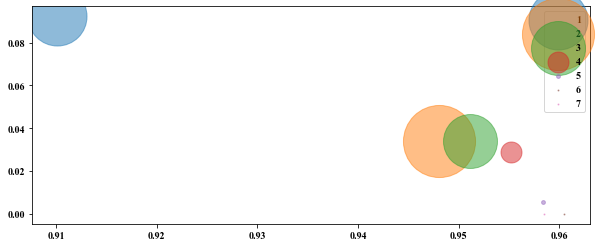

In [33]:
numofdomian2cos = {}
plt.figure(figsize=(10,4))

for n,c in zip(numofdomains, center2cos):
    numofdomian2cos.setdefault(n, []).append(c)

for i in range(1,8):
    mean = np.mean(numofdomian2cos[i])
    std = np.std(numofdomian2cos[i])
    print(i,': ', len(numofdomian2cos[i]))
    plt.scatter(mean, std, len(numofdomian2cos[i])**1.5, alpha=0.5)
    
plt.legend([str(i) for i in range(1,8)])

In [34]:
tdnn_test_score_f = 'Data/xvector/TDNN_v5/cnceleb/klfb_egs_baseline/arcsoft/Mean_STAP_em512_wd5e4_var/test/epoch_50/scores'
tdnn_test_scores = []

with open(os.path.join(data_dir, tdnn_test_score_f), 'r') as f:
    for l in f.readlines():
        s,l = l.split()
        tdnn_test_scores.append((float(s), l))
        
test_domain = []
with open(os.path.join(lstm_dir, 'cnceleb/test/trials'), 'r') as f:
    for l in f.readlines():
        _, test_uid, _ = l.split()
        test_domain.append(test_uid.split('-')[1])

In [35]:
tdnn_test_scores[:1]

[(0.17569156, 'True')]

In [36]:
from Eval.eval_metrics import evaluate_kaldi_eer, evaluate_kaldi_mindcf

In [ ]:
scores = []
labels = []

for (s,l),d in zip(tdnn_test_scores, test_domain):
    s = (s-train_domain_stats[d][0]) / train_domain_stats[d][1]
    scores.append(s)
    if l == 'True':
        labels.append(True)
    else:
        labels.append(False)

eer, eer_threshold, accuracy = evaluate_kaldi_eer(scores, labels, cos=True, re_thre=True)
mindcf_01, mindcf_001 = evaluate_kaldi_mindcf(scores, labels)

In [139]:
domain_score = open('domain_scores', 'w')
with open(os.path.join(lstm_dir, 'cnceleb/test/trials'), 'r') as f:
    i = 0
    for l in f.readlines():
        enroll_uid, test_uid, _ = l.split()
        domain_score.write(enroll_uid + ' ' + test_uid + ' ' + str(scores[i]) +'\n')
        i += 1
#         test_domain.append(test_uid.split('-')[1])

In [ ]:
print(eer)
print(mindcf_01, ' ', mindcf_001)

In [137]:
print(len(labels))

3604800


In [37]:
# miss_uid = []
all_othercos = []
other_dom2cos = {}
other_spks = np.arange(800)

for uid in tqdm(tdnn_xvector_dict, ncols=100):
    this_sid = uid.split('-')[0]
    
    other_spks_idx = np.delete(other_spks, [spk2idx[this_sid]])
    other_spk_center = classifier_Center[:, other_spks_idx]

    this_vector = kaldi_io.read_vec_flt(data_dir + '/'+tdnn_xvector_dict[uid])
    this_cos = torch.nn.functional.cosine_similarity(other_spk_center, torch.tensor(this_vector).reshape(-1, 1).repeat(1,799), dim=0) 
    
    dom = uid.split('-')[1]
    other_dom2cos.setdefault(dom,[]).extend(this_cos.tolist())
    
    all_othercos.extend(this_cos.tolist())

100%|███████████████████████████████████████████████████████| 91824/91824 [00:48<00:00, 1906.92it/s]


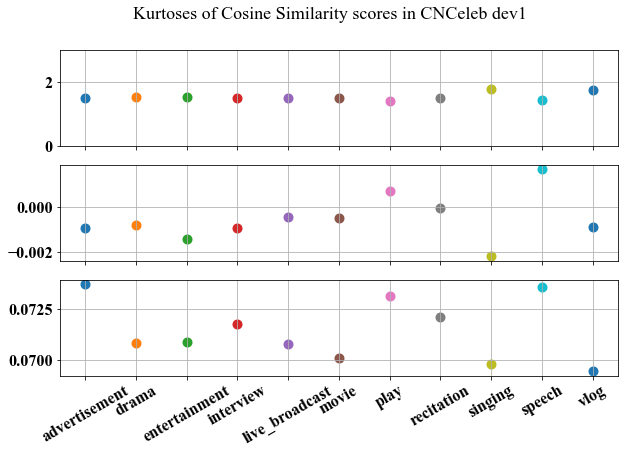

In [38]:
# x = np.arange(0, 2, 0.01)
plt.figure(figsize=(10,6))
plt.suptitle("Kurtoses of Cosine Similarity scores in CNCeleb dev1", fontsize=fontsize+2)
ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)

other_train_domain_stats = {}
for i,dom in enumerate(domains):
    dom_cos = np.array(other_dom2cos[dom])
    
    mean = dom_cos.mean()
    diffs = dom_cos - mean
    var = np.mean(np.power(diffs, 2.0))
    std = np.power(var, 0.5)
    z_scores = diffs / std

    kurtoses = np.mean(np.power(z_scores, 4.0)) - 3.0
    
    ax1.scatter([dom], [kurtoses], marker='o', linewidth=4)
    ax2.scatter([dom], [mean], marker='o', linewidth=4)
    ax3.scatter([dom], [std], marker='o', linewidth=4)
    
    other_train_domain_stats[dom] = [mean, std]

ax1.set_xticklabels([])
ax1.set_ylim(0,3)
ax2.set_xticklabels([])

for ax in [ax1, ax2, ax3]:
    ax.grid()
    
    ax.tick_params(axis='x', labelrotation=30)
    ax.tick_params(axis='both', labelsize=fontsize)


In [143]:
scores = []
labels = []

for (s,l),d in zip(tdnn_test_scores, test_domain):
    s = (s-other_train_domain_stats[d][0]) / other_train_domain_stats[d][1]
    scores.append(s)
    if l == 'True':
        labels.append(True)
    else:
        labels.append(False)

domain_score = open('other_domain_scores', 'w')
with open(os.path.join(lstm_dir, 'cnceleb/test/trials'), 'r') as f:
    i = 0
    for l in f.readlines():
        enroll_uid, test_uid, _ = l.split()
        domain_score.write(enroll_uid + ' ' + test_uid + ' ' + str(scores[i]) +'\n')
        i += 1

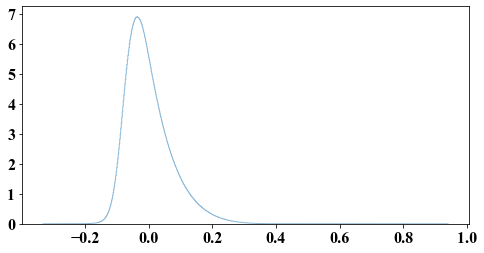

In [144]:
fontsize=16

plt.figure(figsize=(8, 3))

center2cos = np.array(all_othercos)

plt.hist(center2cos, alpha=0.5, bins=800, density=True, histtype='step')
_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)

In [2]:
import torch

In [24]:
half_data = 12
label = torch.randint(0, 20, (half_data*2,))

idx=20

index_list = {}
for i in range(20):
    for j in range(i+1, 20):
        index_list['%d_%d'%(i,j)] = idx
        idx += 1

In [25]:
half_label = label[half_data:]

rand_idx = torch.randperm(half_data)
rand_label = half_label.clone()[rand_idx]

In [27]:
len(index_list)

190

In [13]:
rand_label

tensor([15, 10,  9,  4, 10,  7,  9,  6,  6, 13, 10,  5])

In [19]:
relabel = []

for x,y in zip(half_label, rand_label):
    if x==y:
        relabel.append(int(x))
    elif x<y:
        relabel.append(index_list['%d_%d'%(x,y)])
    else :
        relabel.append(index_list['%d_%d'%(y,x)])
        
relabel = torch.LongTensor(relabel)

In [20]:
relabel

tensor([170,  10, 141, 100, 178, 147,   9,   6,  96, 132,  10,   5])